# A Transformer based Language Model from scratch
> Building transformer with simple building blocks

- toc: true
- branch: master
- badges: true
- comments: true
- author: Arto
- categories: [fastai, pytorch]

In [ ]:
#hide
import sys
if 'google.colab' in sys.modules:
    !pip install -Uqq fastai

In this notebook i'm going to construct transformer based language model from scratch starting with the simplest building blocks. This is inspired by Chapter 12 of [Deep Learning for Coders book](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527) in which it's demonstrated how to create a Recurrent Neural Network. It provides a strong intuition of how RNNs relate to regular feed-forward neural nets and why certain design choices were made. Here we aim to aquire similar kind of intuition about Transfomer based architectures.

But as always we should start with the data to be modeled, 'cause without data any model makes no particular sense.

## Data

Similar to authors of the book I'll use simple Human numbers dataset which is specifically designed to prototyping model fast and straightforward. For more details on the data one can refer to the aforemantioned book chapter which is also available for free as [a notebook](https://github.com/fastai/fastbook/blob/master/12_nlp_dive.ipynb) (isn't that awesome?!)

In [ ]:
from fastai.text.all import *
path = untar_data(URLs.HUMAN_NUMBERS)
Path.BASE_PATH = path
path.ls()

(#2) [Path('train.txt'),Path('valid.txt')]

The data consists of consecutive numbers from 1 to 9999 inclusive spelled as words.

In [ ]:
lines = L()
with open(path/'train.txt') as f: lines += L(*f.readlines())
with open(path/'valid.txt') as f: lines += L(*f.readlines())
lines

(#9998) ['one \n','two \n','three \n','four \n','five \n','six \n','seven \n','eight \n','nine \n','ten \n'...]

In [ ]:
text = ' . '.join([l.strip() for l in lines])
tokens = text.split(' ')
tokens[:10]

['one', '.', 'two', '.', 'three', '.', 'four', '.', 'five', '.']

In [ ]:
vocab = L(*tokens).unique()
vocab

(#30) ['one','.','two','three','four','five','six','seven','eight','nine'...]

In [ ]:
word2idx = {w:i for i,w in enumerate(vocab)}
nums = L(word2idx[i] for i in tokens)
nums

(#63095) [0,1,2,1,3,1,4,1,5,1...]

The task will be to predict subsequent token given preceding three. This kind of tasks when the goal is to predict next token from previous ones is called autoregresive language modeling.

In [ ]:
L((tokens[i:i+3], tokens[i+3]) for i in range(0,len(tokens)-4,3))

(#21031) [(['one', '.', 'two'], '.'),(['.', 'three', '.'], 'four'),(['four', '.', 'five'], '.'),(['.', 'six', '.'], 'seven'),(['seven', '.', 'eight'], '.'),(['.', 'nine', '.'], 'ten'),(['ten', '.', 'eleven'], '.'),(['.', 'twelve', '.'], 'thirteen'),(['thirteen', '.', 'fourteen'], '.'),(['.', 'fifteen', '.'], 'sixteen')...]

In [ ]:
seqs = L((tensor(nums[i:i+3]), nums[i+3]) for i in range(0,len(nums)-4,3))
seqs

(#21031) [(tensor([0, 1, 2]), 1),(tensor([1, 3, 1]), 4),(tensor([4, 1, 5]), 1),(tensor([1, 6, 1]), 7),(tensor([7, 1, 8]), 1),(tensor([1, 9, 1]), 10),(tensor([10,  1, 11]), 1),(tensor([ 1, 12,  1]), 13),(tensor([13,  1, 14]), 1),(tensor([ 1, 15,  1]), 16)...]

In [ ]:
bs = 64
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], bs=64, shuffle=False)

In [ ]:
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 3]), torch.Size([64]))

## Dot product attention

![Multi head attention](https://github.com/fastai/course-v3/blob/master/nbs/dl2/images/attention.png?raw=1 "credit: Attention is all you need")

The core idea behind Transformers is Attention. Since the release of famous paper [Attention is All You Need](https://arxiv.org/abs/1706.03762) transformers has become most popular architecture for language modelling. 

There are a lot of great resourses explaining transformers architecture. I'll list some of those I found useful and comprehensive:
1. [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html) completes the original paper with code
2. [Encoder-Decoder Model](https://colab.research.google.com/github/patrickvonplaten/notebooks/blob/master/Encoder_Decoder_Model.ipynb) notebook by huggingface gives mathemetically grounded explanation of how transformer encoder-decoder models work
3. [The Illustrated GPT-2](https://jalammar.github.io/illustrated-gpt2/) one of the great blogposts by Jay Alammar visualizing generative language modelling on exaple of GPT-2
4. [minGPT](https://github.com/karpathy/minGPT) cool repo by A. Karpathy providing clear minimal implementation of GPT model

There exist multiple attention mechanisms. The particular one used in the original transformer paper is Scaled Dot Product attention.
Given query vector for particular token we will compare it with a key vector for each token in a sequence and decide how much value vectors of those will effect resulting representetion of the token of interest. One way to view this from a linguistic prospective is: a key is a question each word respondes to, value is information that word represent and a query is related to what every word was looking to combine with.

Mathemetically we can compute attention for all _q_, _k_, _v_ in a matrix form:

$$\textbf {Attention}(Q,K,V) = \textbf {softmax}({QK^T\over\sqrt d_k})V $$

Note that dot product $QK^T$ results in matrix of shape (seq_len x seq_len). Then it is devided by $ \sqrt d_k$ to compensate the fact, that longer sequences will have larger dot product. $ \textbf{softmax}$ is applied to rescale the attention matrix to be betwin 0 and 1. When multiplied by $V$ it produces a matrix of the same shape as $V$ (seq_len x dv).

So where those _q_, _k_, _v_ come from. Well that's fairly straitforward queries are culculated from the embeddings of tokens we want to find representation for by simple linear projection. Keys and values are calculated from the embeddings of context tokens. In case of self attention all of them come from the original sequence.

In [ ]:
class SelfAttention(Module):
    def __init__(self, d_in, d_qk, d_v=None):
        d_v = ifnone(d_v, d_qk)
        self.iq = nn.Linear(d_in, d_qk)
        self.ik = nn.Linear(d_in, d_qk)
        self.iv = nn.Linear(d_in, d_v)
        self.out = nn.Linear(d_v, d_in)
        self.scale = d_qk**-0.5
    def forward(self, x):
        q, k, v = self.iq(x), self.ik(x), self.iv(x)
        q *= self.scale
        return self.out(F.softmax(q@k.transpose(-2,-1), -1)@v)

Even though self attention mechanism is extremely useful it posseses limited expressive power. Essentially we are computing weighted some of the input modified by single affine transformation, shared across the whole sequence. To add more computational power to the model we can introduce fully connected feedforward network on top of the SelfAttention layer.

Curious reader can find detailed formal analysis of the roles of SelfAttention and FeedForward layers in transformer architecture in [this paper](https://arxiv.org/pdf/1912.10077.pdf) by C. Yun et al.
In brief the authors state that SelfAttention layers compute precise contextual maps and FeedForward layers then assign the results of these contextual maps to the desired output values.

In [ ]:
class FeedForward(Module):
    def __init__(self, d_in, d_ff):
        self.lin1 = nn.Linear(d_in, d_ff)
        self.lin2 = nn.Linear(d_ff, d_in)
        self.act = nn.ReLU()
        
    def forward(self, x):
        out = self.lin2(self.act(self.lin1(x)))
        return out

The output would be of shape (bs, seq_len, d) which then may be mapped to (bs, seq_len, vocab_sz) using linear layer. But we have only one target. To adress this issue we can simply do average pooling over seq_len dimention.

The resulting model is fairly simple:

In [ ]:
class Model1(Module):
    def __init__(self, vocab_sz, d_model, d_qk, d_ff):
        self.emb = Embedding(vocab_sz, d_model)
        self.attn = SelfAttention(d_model, d_qk)
        self.ff = FeedForward(d_model, d_ff)
        self.out = nn.Linear(d_model, vocab_sz)
    def forward(self, x):
        x = self.emb(x)
        x = self.ff(self.attn(x))
        x = x.mean(1)
        return self.out(x)

In [ ]:
model = Model1(len(vocab), 64, 64, 128)
out = model(x)
out.shape

torch.Size([64, 30])

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.019054606556892395)

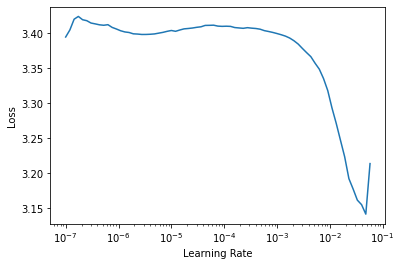

In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.023451,2.183568,0.416211,00:03
1,1.563715,2.401872,0.361540,00:03
2,1.540635,1.874314,0.452817,00:03
3,1.594812,1.739459,0.456145,00:03
4,1.614958,1.713703,0.468743,00:03


To evaluete the model performance we need to compare it to some baseline. Let's see what would be the accuracy if of the model which would always predict most common token.

In [ ]:
n,counts = 0,torch.zeros(len(vocab))
for x,y in dls.valid:
    n += y.shape[0]
    for i in range_of(vocab): counts[i] += (y==i).long().sum()
idx = torch.argmax(counts)
idx, vocab[idx.item()], counts[idx].item()/n

(tensor(29), 'thousand', 0.15165200855716662)

As you can see, always predicting "thousand" which turn out to be the most common token in the dataset would result in ~15% accuracy. Our simple transformer does much better then that. It feels promising, so let's try to improve the architecture and check if we can get better results.

### Multihead attention

A structured sequence may comprise multiple distinctive kinds of relationships. Our model is forced to learn only one way in which queries, keys and values are constructed from the original token embedding. To remove this limitation we can modify attention layer include multiple heads which would correspond to extracting different kinds of relationships between tokens. The MultiHeadAttention layer consits of several heads each of those is similar to SelfAttention layer we made before. To keep computational cost of the multi-head layer we set $d_k = d_v = d_{model}/n_h$, where $n_h$ is number of heads.

In [ ]:
class SelfAttention(Module):
    def __init__(self, d_in, d_qk, d_v=None):
        d_v = ifnone(d_v, d_qk)
        self.iq = nn.Linear(d_in, d_qk)
        self.ik = nn.Linear(d_in, d_qk)
        self.iv = nn.Linear(d_in, d_v)
        self.scale = d_qk**-0.5
    def forward(self, x):
        q, k, v = self.iq(x), self.ik(x), self.iv(x)
        return F.softmax(q@k.transpose(-2,-1)*self.scale, -1)@v

In [ ]:
class MultiHeadAttention(Module):
    def __init__(self, d_model, n_heads, d_qk=None, d_v=None):
        d_qk = ifnone(d_qk, d_model//n_heads)
        d_v = ifnone(d_v, d_qk)
        self.heads = nn.ModuleList([SelfAttention(d_model, d_qk) for _ in range(n_heads)])
        self.out = nn.Linear(d_v*n_heads, d_model)
        
    def forward(self, x):
        out = [m(x) for m in self.heads]
        return self.out(torch.cat(out, -1))

In [ ]:
inp = torch.randn(8, 10, 64)
mha = MultiHeadAttention(64, 8)
out = mha(inp)
out.shape

torch.Size([8, 10, 64])

In [ ]:
class Model2(Module):
    def __init__(self, vocab_sz, d_model=64, n_heads=4, d_ff=64*4):
        self.emb = nn.Embedding(vocab_sz, d_model)
        self.attn = MultiHeadAttention(d_model, n_heads)
        self.ff = FeedForward(d_model, d_ff)
        self.out = nn.Linear(d_model, vocab_sz)
    def forward(self, x):
        x = self.emb(x)
        x = self.ff(self.attn(x))
        x = x.mean(1)
        return self.out(x)

In [ ]:
learn = Learner(dls, Model2(len(vocab)), loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.177783,2.223564,0.332303,00:04
1,1.629889,1.867587,0.445210,00:04
2,1.607201,1.738342,0.464464,00:04
3,1.606301,1.711135,0.467316,00:04
4,1.592446,1.708671,0.467554,00:04


### MultiHead Attention Refactor

Python `for` loops are slow, therefore it is better to refactor the MultiHeadAttention module to compute Q, K, V for all heads in batch.

In [ ]:
class MultiHeadAttention(Module):
    def __init__(self, d_model, n_heads):
        assert d_model%n_heads == 0
        self.n_heads = n_heads
        #d_qk, d_v = d_model//n_heads, d_model//n_heads
        self.iq = nn.Linear(d_model, d_model, bias=False)
        self.ik = nn.Linear(d_model, d_model, bias=False)
        self.iv = nn.Linear(d_model, d_model, bias=False)
        self.out = nn.Linear(d_model, d_model, bias=False)
        self.scale = d_model//n_heads
        
    def forward(self, x):
        bs, seq_len, d = x.size()
        # (bs,sl,d) -> (bs,sl,nh,dh) -> (bs,nh,sl,dh)
        q = self.iq(x).view(bs, seq_len, self.n_heads, d//self.n_heads).transpose(1, 2)
        k = self.ik(x).view(bs, seq_len, self.n_heads, d//self.n_heads).transpose(1, 2)
        v = self.iv(x).view(bs, seq_len, self.n_heads, d//self.n_heads).transpose(1, 2)
        q*= self.scale
        att = F.softmax(q@k.transpose(-2,-1), -1)
        out = att @ v # (bs, nh, sl, sl) x (bs, nh, sl, dh) -> (bs, nh, sl, dh)
        out = out.transpose(1, 2).contiguous().view(bs, seq_len, d) # back to original shape
        return self.out(out)

In [ ]:
learn = Learner(dls, Model2(len(vocab)), loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.945255,2.148961,0.362729,00:03
1,1.576766,2.055920,0.426432,00:03
2,1.599834,1.934431,0.443784,00:03
3,1.624774,1.742481,0.460185,00:03
4,1.615320,1.773680,0.452817,00:03


Note that some speedup is observed even on such a tiny dataset and small model.

## More signal

Similarly to the RNN case considered in the book, we can take the next step and create more signal for the model to learn from. To adapt to the modified objective we need to make couple of steps. First let's rearrange data to proper input-target pairs for the new task.

### Arranging data

Unlike RNN the tranformer is not a stateful model. This means it treats each sequence indepently and can only attend within fixed length context. This limitation was addressed by authors of [Transformer-XL paper](https://arxiv.org/abs/1901.02860) where adding a segment-level recurrence mechanism and a novel positional encoding scheme were proposed to enable capturing long-term dependencies. I will not go into details of TransformerXL architecture here. As we shell see stateless transformer can also learn a lot about the structure of our data.

One thing to note in this case is that we don't need to maintain the structure of the data outside of the sequences, so we can shuffle the sequences randomly in the dataloader.

In [ ]:
sl = 16
seqs = L((tensor(nums[i:i+sl]), tensor(nums[i+1:i+sl+1]))
         for i in range(0,len(nums)-sl-1,sl))
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:],
                             bs=bs, drop_last=True, shuffle=True)
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 16]), torch.Size([64, 16]))

In [ ]:
[L(vocab[o] for o in s) for s in seqs[0]]

[(#16) ['one','.','two','.','three','.','four','.','five','.'...],
 (#16) ['.','two','.','three','.','four','.','five','.','six'...]]

### Positional encoding

Before we did average pooling over seq_len dimension. Our model didn't care about the order of the tokens at all. But actually order of the tokens in a sentence matter a lot. In our case `one hundred two` and `two hundred one` are pretty different and `hundred one two` doesn't make sense.

To encorporate positional information into the model authors of the transformer architecture proposed to use positional encodings in addition to regular token embeddings. Positional encodings may be learned, but it's also possible to use hardcoded encodings. For instance encodings may be composed of sin and cos.
In this way each position in a sequence will get unique vector associated with it.

In [ ]:
class PositionalEncoding(Module):
    def __init__(self, d):
        self.register_buffer('freq', 1/(10000 ** (torch.arange(0., d, 2.)/d)))
        self.scale = d**0.5
    def forward(self, x):
        device = x.device
        pos_enc = torch.cat([torch.sin(torch.outer(torch.arange(x.size(1), device=device), self.freq)),
                             torch.cos(torch.outer(torch.arange(x.size(1), device=device), self.freq))],
                            axis=-1)
        return x*self.scale + pos_enc

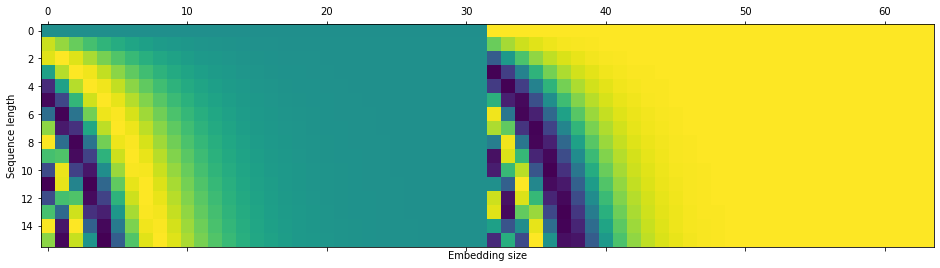

In [ ]:
#collapse-hide
x = torch.zeros(1, 16, 64)
encs = PositionalEncoding(64)(x)
plt.matshow(encs.squeeze())
plt.xlabel('Embedding size')
plt.ylabel('Sequence length')
plt.show()

In [ ]:
class TransformerEmbedding(Module):
    def __init__(self, emb_sz, d_model):
        self.emb = nn.Embedding(emb_sz, d_model)
        self.pos_enc = PositionalEncoding(d_model)
    def forward(self, x):
        return self.pos_enc(self.emb(x))

In [ ]:
class Model3(Module):
    def __init__(self, vocab_sz, d_model=64, n_heads=4, d_ff=64*4):
        self.emb = TransformerEmbedding(vocab_sz, d_model)
        self.attn = MultiHeadAttention(d_model, n_heads)
        self.ff = FeedForward(d_model, d_ff)
        self.out = nn.Linear(d_model, vocab_sz)
    def forward(self, x):
        x = self.emb(x)
        x = self.ff(self.attn(x))
        return self.out(x)

In [ ]:
model = Model3(len(vocab))
out = model(xb)
out.shape

torch.Size([64, 16, 30])

In [ ]:
def loss_func(inp, targ):
    return F.cross_entropy(inp.view(-1, len(vocab)), targ.view(-1))

In [ ]:
learn = Learner(dls, Model3(len(vocab)), loss_func=loss_func, metrics=accuracy)
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.059098,1.966106,0.244059,00:01
1,0.996265,0.151726,0.956055,00:01
2,0.427699,0.078305,0.977865,00:01
3,0.207902,0.066726,0.976481,00:01
4,0.116920,0.074462,0.974935,00:01


Wow! That's a great accuracy! So the problem is solved and we only needed one attention layer and 2 layer deep feed-forward block? Don't you feel somewhat skeptical about this result?

Well, you should be! Think about what we did here: the goal was to predict a target sequence, say `['.','two','.','three','.','four']` from an input `['one','.','two','.','three','.']`. These two sequences intersect on all positions except the first and the last one. So models needs to learn simply to copy input tokens starting from the second one to the outputs. In our case this will result in 15 correct predictions of total 16 positions, that's almost 94% accuracy. This makes the task very simple but not very useful to learn. To train proper autoregressive language model, as we did with RNNs, a concept of masking is to be introduced.

### Causal Masking

So we want to allow the model for each token to attend only to itself and those prior to it. To acomplish this we can set all the values of attention matrix above the main diagonal to $-\infty$. After softmax this values will effectively turn to 0 thus disabling attention to the "future".

In [ ]:
def get_subsequent_mask(x):
    sz = x.size(1)
    mask = (torch.triu(torch.ones(sz, sz, device=x.device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

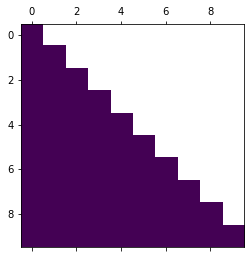

In [ ]:
inp = torch.randn(8, 10, 64)
mask = get_subsequent_mask(inp)
plt.matshow(mask);

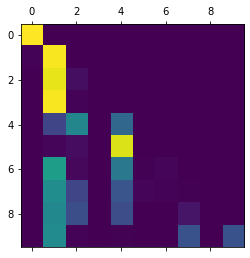

In [ ]:
q, k = torch.rand(1,10,32), torch.randn(1,10,32)
att_ = F.softmax((q@k.permute(0,2,1)+mask), -1)
plt.matshow(att_[0].detach());

We should also modify the attention layer to accept mask:

In [ ]:
class MultiHeadAttention(Module):
    def __init__(self, d_model, n_heads):
        assert d_model%n_heads == 0
        self.n_heads = n_heads
        d_qk, d_v = d_model//n_heads, d_model//n_heads
        self.iq = nn.Linear(d_model, d_model, bias=False)
        self.ik = nn.Linear(d_model, d_model, bias=False)
        self.iv = nn.Linear(d_model, d_model, bias=False)
        self.scale = d_qk**-0.5
        self.out = nn.Linear(d_model, d_model, bias=False)
        
    def forward(self, x, mask=None):
        bs, seq_len, d = x.size()
        mask = ifnone(mask, 0)
        q = self.iq(x).view(bs, seq_len, self.n_heads, d//self.n_heads).transpose(1, 2)
        k = self.ik(x).view(bs, seq_len, self.n_heads, d//self.n_heads).transpose(1, 2)
        v = self.iv(x).view(bs, seq_len, self.n_heads, d//self.n_heads).transpose(1, 2)
        q*= self.scale
        att = F.softmax(q@k.transpose(-2,-1) + mask, -1)
        
        out = att @ v # (bs, nh, sl, sl) x (bs, nh, sl, dh) -> (bs, nh, sl, dh)
        out = out.transpose(1, 2).contiguous().view(bs, seq_len, d) # back to original shape

        return self.out(out)

In [ ]:
class Model4(Module):
    def __init__(self, vocab_sz, d_model=64, n_heads=8, d_ff=64*4):
        self.emb = TransformerEmbedding(vocab_sz, d_model)
        self.attn = MultiHeadAttention(d_model, n_heads)
        self.ff = FeedForward(d_model, d_ff)
        self.out = nn.Linear(d_model, vocab_sz)
    def forward(self, x):
        x = self.emb(x)
        mask = get_subsequent_mask(x)
        x = self.ff(self.attn(x, mask))
        return self.out(x)

In [ ]:
learn = Learner(dls, Model4(len(vocab)), loss_func=loss_func, metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.399806,2.321602,0.262533,00:01
1,1.804210,2.251197,0.251709,00:01
2,1.559652,2.320621,0.282878,00:01
3,1.426687,2.365385,0.281006,00:01
4,1.355069,2.430914,0.301025,00:01


Now we get somewhat lower accuracy, which is expected given that the task has become more difficult. Also training loss is significantly lower than validation loss, which means the model is overfitting. Let's see if the same approaches as was applied to RNNs can help.

### Multilayer transformer

To solve a more difficult task we ussualy need a deeper model. For convenience let's make a TransformerLayer which will combine self-attention and feed-forward blocks.

In [ ]:
class TransformerLayer(Module):
    def __init__(self, d_model, n_heads=8, d_ff=None, causal=True):
        d_ff = ifnone(d_ff, 4*d_model)
        self.attn = MultiHeadAttention(d_model, n_heads)
        self.ff = FeedForward(d_model, d_ff)
        self.causal = causal
    def forward(self, x, mask=None):
        if self.causal:
            mask = get_subsequent_mask(x)
        return self.ff(self.attn(x, mask))

In [ ]:
class Model5(Module):
    def __init__(self, vocab_sz, d_model=64, n_layer=4, n_heads=8):
        self.emb = TransformerEmbedding(vocab_sz, d_model)
        self.encoder = nn.Sequential(*[TransformerLayer(d_model, n_heads) for _ in range(n_layer)])
        self.out = nn.Linear(d_model, vocab_sz)
    def forward(self, x):
        x = self.emb(x)
        x = self.encoder(x)
        return self.out(x)

In [ ]:
learn = Learner(dls, Model5(len(vocab), n_layer=4), loss_func=loss_func, metrics=accuracy)
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.896548,2.794600,0.151611,00:03
1,2.790987,2.813897,0.151774,00:03
2,2.769421,2.791088,0.151774,00:04
3,2.756661,2.790368,0.151367,00:04
4,2.748009,2.799597,0.150960,00:04


That's not good! 4 layer deep Transformer strugles to learn anything. But there are good news, this problem has been already resolved in the original transformer.

### Residual connections and Regularization

If you are familiar with ResNets the proposed solution will not surprise you much. The idea is simple yet very effective. Instead of returning modified output $f(x)$ each transformer sublayer will return $x + f(x)$. This allows the original input to propagate freely through the model. So the model learns not an entirely new representation of $x$ but how to modify $x$ to add some useful information to the original representation.

As we modify layers to include the residual connections let's also add some regularization by inserting Dropout layers.

In [ ]:
class TransformerEmbedding(Module):
    def __init__(self, emb_sz, d_model, p=0.1):
        self.emb = Embedding(emb_sz, d_model)
        nn.init.trunc_normal_(self.emb.weight, std=d_model**-0.5)
        self.pos_enc = PositionalEncoding(d_model)
        self.drop = nn.Dropout(p)
    def forward(self, x):
        return self.drop(self.pos_enc(self.emb(x)))

Another modification is to add layer normalization which is intended to improve learning dynamics of the network by reparametrising data statistics and is generally used in transformer based architectures.

In [ ]:
class FeedForward(Module):
    def __init__(self, d_model, d_ff, p=0.2):
        self.lin1 = nn.Linear(d_model, d_ff)
        self.lin2 = nn.Linear(d_ff, d_model)
        self.act = nn.ReLU()
        self.norm = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(p)
    def forward(self, x):
        x = self.norm(x)
        out = self.act(self.lin1(x))
        out = self.lin2(out)
        return x + self.drop(out)

In [ ]:
class MultiHeadAttention(Module):
    def __init__(self, d_model, n_heads, p=0.1):
        assert d_model%n_heads == 0
        self.n_heads = n_heads
        d_qk, d_v = d_model//n_heads, d_model//n_heads
        self.iq = nn.Linear(d_model, d_model, bias=False)
        self.ik = nn.Linear(d_model, d_model, bias=False)
        self.iv = nn.Linear(d_model, d_model, bias=False)
        self.scale = d_qk**0.5
        self.out = nn.Linear(d_model, d_model, bias=False)
        self.norm = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(p)
    def forward(self, x, mask=None):
        bs, seq_len, d = x.size()
        mask = ifnone(mask, 0)
        x = self.norm(x)
        k = self.ik(x).view(bs, seq_len, self.n_heads, d//self.n_heads).transpose(1, 2)
        q = self.iq(x).view(bs, seq_len, self.n_heads, d//self.n_heads).transpose(1, 2)
        v = self.iv(x).view(bs, seq_len, self.n_heads, d//self.n_heads).transpose(1, 2)
        att = F.softmax(q@k.transpose(-2,-1)/self.scale + mask, -1)
        
        out = att @ v # (bs, nh, sl, sl) x (bs, nh, sl, dh) -> (bs, nh, sl, dh)
        out = out.transpose(1, 2).contiguous().view(bs, seq_len, d) # back to original shape

        return x + self.drop(self.out(out))

In [ ]:
class TransformerLayer(Module):
    def __init__(self, d_model, n_heads=8, d_ff=None, causal=True,
                 p_att=0.1, p_ff=0.1):
        d_ff = ifnone(d_ff, 4*d_model)
        self.attn = MultiHeadAttention(d_model, n_heads)
        self.ff = FeedForward(d_model, d_ff, p=p_ff)
        self.causal = causal
        self._init()
    def forward(self, x, mask=None):
        if self.causal:
            mask = get_subsequent_mask(x)
        return self.ff(self.attn(x, mask))
    def _init(self):
        for p in self.parameters():
            if p.dim()>1: nn.init.xavier_uniform_(p)

In [ ]:
class Model6(Module):
    def __init__(self, vocab_sz, d_model=64, n_layer=4, n_heads=8, 
                 p_emb=0.1, p_att=0.1, p_ff=0.2, tie_weights=True):
        self.emb = TransformerEmbedding(vocab_sz, d_model, p=p_emb)
        self.encoder = nn.Sequential(*[TransformerLayer(d_model, n_heads,
                                                     p_att=p_att, p_ff=p_ff)
                                    for _ in range(n_layer)],
                                    nn.LayerNorm(d_model))
        self.out = nn.Linear(d_model, vocab_sz)
        if tie_weights: self.out.weight = self.emb.emb.weight
    def forward(self, x):
        x = self.emb(x)
        x = self.encoder(x)
        return self.out(x)

In [ ]:
learn = Learner(dls, Model6(len(vocab), n_layer=2), loss_func=loss_func, metrics=accuracy)
learn.fit_one_cycle(8, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.635322,2.077494,0.193929,00:02
1,1.751456,1.042653,0.667806,00:02
2,1.120504,0.743249,0.767822,00:02
3,0.825433,0.797066,0.733643,00:02
4,0.687212,0.747418,0.751058,00:02
5,0.615355,0.815827,0.747233,00:02
6,0.576437,0.809159,0.751302,00:02
7,0.557015,0.823612,0.744466,00:02


## Bonus - Generation example

In [ ]:
#hide
from google.colab import drive

drive.mount('/content/drive')
path = Path('/content/drive/MyDrive/char_model')

Mounted at /content/drive


Learning to predict numbers is great, but let's try something more entertaining. We can train a language model to generate texts. For example let's try to generate some text in style of Lewis Carroll. For this we'll fit a language model on "Alice in Wonderland" and "Through the looking glass".

In [ ]:
#collapse-hide
def parse_txt(fns):
    txts = []
    for fn in fns:
        with open(fn) as f:
            tmp = ''
            for line in f.readlines():
                line = line.strip('\n')
                if line:
                    tmp += ' ' + line
                elif tmp:
                    txts.append(tmp.strip())
                    tmp = ''
    return txts

In [ ]:
texts = parse_txt([path/'11-0.txt', path/'12-0.txt'])

In [ ]:
len(texts)

1779

In [ ]:
texts[0:2]

['\ufeffCHAPTER I. Down the Rabbit-Hole',
 'Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, “and what is the use of a book,” thought Alice “without pictures or conversations?”']

In [ ]:
#collapse-hide
class CharTokenizer(Transform):
    "Simple charecter level tokenizer"
    def __init__(self, vocab=None):
        self.vocab = ifnone(vocab, ['', 'xxbos', 'xxeos'] + list(string.printable))
        self.c2i = defaultdict(int, [(c,i) for i, c in enumerate(self.vocab)])
    def encodes(self, s, add_bos=False, add_eos=False):
        strt = [self.c2i['xxbos']] if add_bos else []
        end = [self.c2i['xxeos']] if add_eos else []
        return LMTensorText(strt + [self.c2i[c] for c in s] + end)
    def decodes(self, s, remove_special=False):
        return TitledStr(''.join([self.decode_one(i) for i in s]))
    def decode_one(self, i):
        if i == 2: return '\n'
        elif i == 1: return ''
        else: return self.vocab[i]
    @property
    def vocab_sz(self):
        return len(self.vocab)


In [ ]:
tok = CharTokenizer()

In [ ]:
def add_bos_eos(x:list, bos_id=1, eos_id=2):
    return [bos_id] + x + [eos_id]

In [ ]:
nums = [add_bos_eos(tok(t.lower()).tolist()) for t in texts]

In [ ]:
len(nums)

1779

In [ ]:
all_nums = []
for n in nums: all_nums.extend(n)

In [ ]:
all_nums[:15]

[1, 0, 15, 20, 13, 28, 32, 17, 30, 97, 21, 78, 97, 16, 27]

In [ ]:
print(tok.decode(all_nums[:100]))

chapter i. down the rabbit-hole
alice was beginning to get very tired of sitting by her sister on


In [ ]:
sl = 512
seqs = L((tensor(all_nums[i:i+sl]), tensor(all_nums[i+1:i+sl+1]))
         for i in range(0,len(all_nums)-sl-1,sl))
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], device='cuda',
                             bs=8, drop_last=True, shuffle=True)
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([8, 512]), torch.Size([8, 512]))

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.6309573650360107)

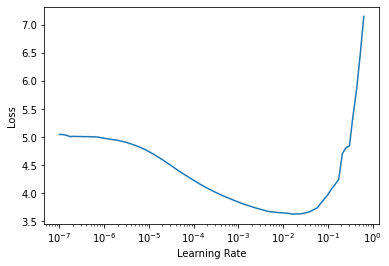

In [ ]:
model = Model6(tok.vocab_sz, 512, 6, p_emb=0.1, p_ff=0.1, tie_weights=True)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, perplexity]).to_native_fp16()
learn.lr_find()

In [ ]:
#collapse_output
learn.fit_one_cycle(50, 5e-4, cbs=EarlyStoppingCallback(patience=5))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.207689,3.014779,0.187012,20.384583,00:06
1,2.957462,2.648416,0.258105,14.131640,00:06
2,2.645952,2.427977,0.287435,11.335924,00:07
3,2.499318,2.395460,0.292887,10.973244,00:07
4,2.436253,2.394616,0.288965,10.963985,00:07
5,2.402833,2.364455,0.295703,10.638234,00:07
6,2.387243,2.367871,0.290381,10.674637,00:07
7,2.375951,2.384834,0.285010,10.857258,00:07
8,2.372440,2.380138,0.276270,10.806398,00:07
9,2.355436,2.329239,0.305892,10.270120,00:07


No improvement since epoch 25: early stopping


### Text generation

Text generation is a big topic on it's own. One can refer to great posts [by Patrick von Platen from HuggingFace](https://huggingface.co/blog/how-to-generate) and [Lilian Weng](https://lilianweng.github.io/lil-log/2021/01/02/controllable-neural-text-generation.html) for more details on various approaches. Here I will use nucleus sampling. This method rallies on sampling from candidates compounding certain value of probability mass. Intuitively this approach should work for character level generation: when there is only one grammatically correct option for continuation we always want to select it, but when starting a new word some diversity in outputs is desirable.

In [ ]:
#collapse-hide
def expand_dim1(x):
    if len(x.shape) == 1:
        return x[None, :]
    else: return x

def top_p_filter(logits, top_p=0.9):
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cum_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

    sorted_indices_to_remove = cum_probs > top_p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0
    indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
    logits[indices_to_remove] = float('-inf')
    return logits

@torch.no_grad()
def generate(model, inp,
            max_len=50,
            temperature=1.,
            top_k = 20,
            top_p = 0.9,
            early_stopping=False, #need eos_idx to work
            eos_idx=None):
    model.to(inp.device)
    model.eval()
    thresh = top_p
    inp = expand_dim1(inp)
    b, t = inp.shape
    out = inp
    for _ in range(max_len):
        x = out

        logits = model(x)[:, -1, :]
        filtered_logits = top_p_filter(logits)
        probs = F.softmax(filtered_logits / temperature, dim=-1)
        sample = torch.multinomial(probs, 1)

        out = torch.cat((out, sample), dim=-1)

        if early_stopping and (sample == eos_idx).all():
            break
    return out

In [ ]:
out = generate(learn.model, tok('Alice said '), max_len=200, early_stopping=True, eos_idx=tok.c2i['xxeos'])

In [ ]:
print(tok.decode(out[0]))

Alice said in a minute turn, only purind his with it migut at in musible. i cant elp out my why yested it to like thought: i know i did it wish indeed it hope?



Our relatively simple model learned to generate mostly grammatically plausible text, but it's not entirely coherent. But it would be too much to ask from the model to learn language from scratch by "reading" only two novels (however great those novels are).  To get more from the model let's feed it larger corpus of data.

### Pretraining on larger dataset

In [ ]:
#hide
import sys
if 'google.colab' in sys.modules:
    !pip install -Uqq datasets

from datasets import load_dataset

     |████████████████████████████████| 163kB 14.0MB/s 
     |████████████████████████████████| 17.7MB 207kB/s 
     |████████████████████████████████| 245kB 54.7MB/s 


For this purpose I will use a sample from [bookcorpus dataset](https://huggingface.co/datasets/bookcorpus). 

In [ ]:
#hide_ouput
dataset = load_dataset("bookcorpus", split='train')

Dataset bookcorpus downloaded and prepared to /root/.cache/huggingface/datasets/bookcorpus/plain_text/1.0.0/af844be26c089fb64810e9f2cd841954fd8bd596d6ddd26326e4c70e2b8c96fc. Subsequent calls will reuse this data.


In [ ]:
df = pd.DataFrame(dataset[:10_000_000])
df.head()

,text
0,the half-ling book one in the fall of igneeria series kaylee soderburg copyright 2013 kaylee soderburg all rights reserved .
1,"isbn : 1492913731 isbn-13 : 978-1492913733 for my family , who encouraged me to never stop fighting for my dreams chapter 1 summer vacations supposed to be fun , right ?"
2,i wish i had a better answer to that question .
3,"starlings , new york is not the place youd expect much to happen ."
4,"its a small quiet town , the kind where everyone knows your name ."


In [ ]:
df['len'] = df['text'].str.len()

In [ ]:
cut = int(len(df)*0.8)
splits = range_of(df)[:cut], range_of(df[cut:])
tfms = Pipeline([ColReader('text'), tok])
dsets = Datasets(df, tfms=tfms, dl_type=LMDataLoader, splits=splits)

In [ ]:
#collapse
@patch
def create_item(self:LMDataLoader, seq):
    if seq>=self.n: raise IndexError
    sl = self.last_len if seq//self.bs==self.n_batches-1 else self.seq_len
    st = (seq%self.bs)*self.bl + (seq//self.bs)*self.seq_len
    txt = self.chunks[st : st+sl+1]    
    return LMTensorText(txt[:-1]),txt[1:]

In [ ]:
%%time
dl_kwargs = [{'lens':df['len'].values[splits[0]]}, {'val_lens':df['len'].values[splits[1]]}]
dls = dsets.dataloaders(bs=32, seq_len=512, dl_kwargs=dl_kwargs, shuffle_train=True, num_workers=2)

CPU times: user 13min 29s, sys: 13 s, total: 13min 42s
Wall time: 13min 35s


In [ ]:
dls.show_batch(max_n=2)

,text,text_
0,"im sorry .`` ah , this is katrice , the rowan queen , coming toward us . ''i said ill tell you !but she still did n't understand why he was a slave here .the sprites had come to believe by now that they were a forgotten people .thats what happened .well have to take him with us for a ways and then let him go .nick stifled the fear in him that was trying to take over .crouching down behind the stone balusters , with every nerve tingling , valeria glared down at the stealthy figure .there did seem to be shado","m sorry .`` ah , this is katrice , the rowan queen , coming toward us . ''i said ill tell you !but she still did n't understand why he was a slave here .the sprites had come to believe by now that they were a forgotten people .thats what happened .well have to take him with us for a ways and then let him go .nick stifled the fear in him that was trying to take over .crouching down behind the stone balusters , with every nerve tingling , valeria glared down at the stealthy figure .there did seem to be shadow"
1,"habitants were genuine , hard working , proud and tough .sergeant colon 's view of the world was certainly changing .'we did n't want any part of it , ' the grandfather continued , heedless of his company , 'but maybe that 's just how the rhega are destined to die ... not by our own hands , our own fights .she looked enquiring , but no one took any notice of her .more land would n't save his people-they needed something else .the other got off a single shot of his .45 caliber pistol before he was clawed acr","abitants were genuine , hard working , proud and tough .sergeant colon 's view of the world was certainly changing .'we did n't want any part of it , ' the grandfather continued , heedless of his company , 'but maybe that 's just how the rhega are destined to die ... not by our own hands , our own fights .she looked enquiring , but no one took any notice of her .more land would n't save his people-they needed something else .the other got off a single shot of his .45 caliber pistol before he was clawed acro"


SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.5248074531555176)

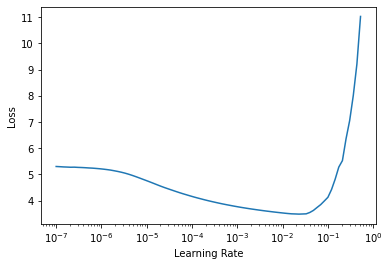

In [ ]:
model = Model6(tok.vocab_sz, 512, 8, p_emb=0.1, p_ff=0.1, tie_weights=True)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, perplexity]).to_native_fp16()
learn.lr_find()

In [ ]:
learn = learn.load(path/'char_bookcorpus_10m')

In [ ]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.065701,1.064358,0.667121,2.898976,4:23:52


In [ ]:
learn.save(path/'char_bookcorpus_10m')

Path('/content/drive/MyDrive/char_model/char_bookcorpus_10m.pth')

### Finetune on Carrolls' books

Finally we can finetune the pretrained bookcorpus model on Carroll's books. This will determine the style of generated text.

In [ ]:
sl = 512
seqs = L((tensor(all_nums[i:i+sl]), tensor(all_nums[i+1:i+sl+1]))
         for i in range(0,len(all_nums)-sl-1,sl))
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], device='cuda',
                             bs=16, drop_last=True, shuffle=True)

In [ ]:
model = Model6(tok.vocab_sz, 512, 8, p_emb=0.1, p_ff=0.1, tie_weights=True)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, perplexity]).to_native_fp16()

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.25118863582611084)

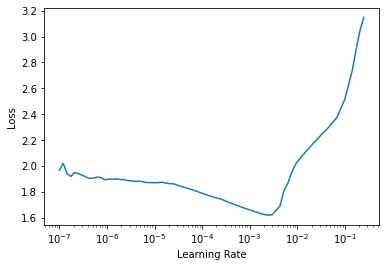

In [ ]:
learn = learn.load(path/'char_bookcorpus_10m')
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.744969,1.472124,0.618443,4.358481,00:08
1,1.442924,1.128739,0.658796,3.091756,00:08
2,1.248169,1.068535,0.670881,2.911111,00:08
3,1.134621,1.048366,0.675764,2.852986,00:08
4,1.058302,1.044972,0.678554,2.843319,00:08
5,1.004934,1.036241,0.680333,2.818603,00:08
6,0.966509,1.042076,0.679461,2.835096,00:08
7,0.938987,1.040590,0.680507,2.830886,00:08
8,0.920266,1.035050,0.681728,2.815248,00:08
9,0.907935,1.037062,0.681257,2.820917,00:08


As you see pretraining model on large corpus followed by finetuning helped to reduce validation loss from arount 1.53 to 1.037 and improve accuracy in predicting next character to 68% (compared to 56.7% before). Let's see how it effects sampled text:

In [ ]:
out = generate(learn.model, tok('Alice said '), max_len=200, early_stopping=True, eos_idx=tok.c2i['xxeos'])

In [ ]:
#collapse-hide
print(tok.decode(out[0]))

Alice said what you want is, why, if you cant see a little rather from people to bed their moment, when birds began drinking from behind, and offering the cart to say something, and dripping off a strange mou


In [ ]:
#hide
learn.save(path/'char_alice')

Path('/content/drive/MyDrive/char_model/char_alice.pth')